<a href="https://colab.research.google.com/github/owaisorakzai/Computer-Vision/blob/main/Signature%20Verification%20CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
from keras.models import Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import joblib
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
import cv2 as cv
from sklearn.utils import shuffle
from keras.utils.vis_utils import plot_model
import cv2
import os
import glob



In [9]:

train_path = 'drive/MyDrive/signature_dataset/Train' #Path to dataset in google drive
SIZE=224
train_data = []
train_labels = []
#Import data from 
for data in glob.glob(train_path+'/Fake/*.png*'): #Import all images of 'Fake' class
  img = cv2.imread(data)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (SIZE,SIZE)) #Resizing image to fit for VGG16 Model
  train_data.append([img]) #Add image to list of training data
  train_labels.append(np.array(1)) #Add corresponding label of image (1)
for data in glob.glob(train_path+'/Real/*.png*'): #Import all images of 'Fake' class
  img = cv2.imread(data)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (SIZE,SIZE)) #Resizing image to fit for VGG16 Model
  train_data.append([img]) #Add image to list of training data
  train_labels.append(np.array(0)) #Add corresponding label of image (0)
train_data = np.array(train_data)/255.0 #Normalise pixels of training data 
train_labels = np.array(train_labels) #Add labels of training data to numpy array

In [10]:
train_labels = to_categorical(train_labels) #Convert labels to One-Hot encoding 
train_data = train_data.reshape(-1, SIZE,SIZE, 3) #Reshape dataset from (1649,1,224,224,3) to (1649,224,224,3)
train_data,train_labels = shuffle(train_data,train_labels) #shuffle dataset to mix training examples


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

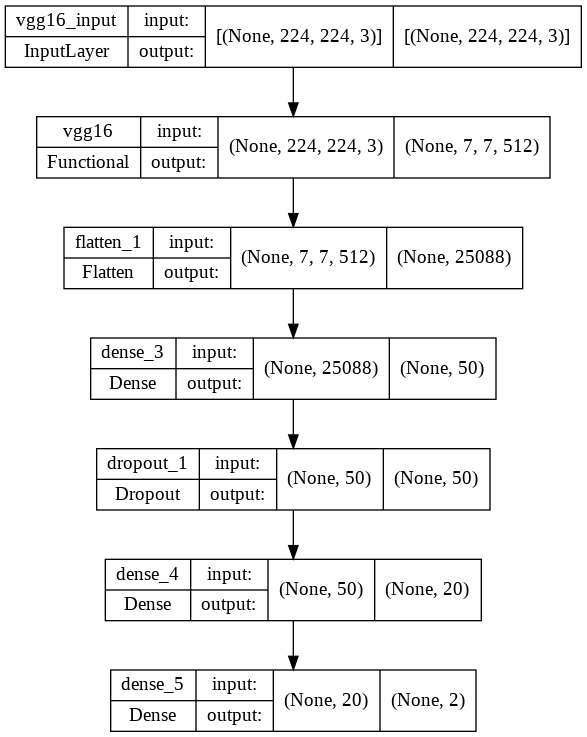

In [11]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(SIZE,SIZE,3)) #import vgg16 model
base_model.trainable = False #Freezing layers of model
base_model.summary()
flatten_layer = layers.Flatten() #
dense_layer_1 = layers.Dense(50, activation='relu') #Dense layer with 50 Neurons
dropout = layers.Dropout(0.4) #Droput layer to decrease overfitting
dense_layer_2 = layers.Dense(20, activation='relu') #Dense layer with 20 Neurons
prediction_layer = layers.Dense(2, activation='softmax') #Output layer with 2 neurons
model = models.Sequential([ #Building model heirarchy
    base_model,
    flatten_layer,
    dense_layer_1,
    dropout,
    dense_layer_2,
    prediction_layer
])
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [12]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'],) #Model settings
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True) #Early stopping to avoid overfitting
history=model.fit(train_data,train_labels,validation_split=.3, epochs=20 ,callbacks=[es]) #Model Training

Epoch 1/20
17/17 [==============================] - 5s 245ms/step - loss: 0.6874 - accuracy: 0.7570 - val_loss: 0.2214 - val_accuracy: 0.9267
Epoch 2/20
17/17 [==============================] - 4s 223ms/step - loss: 0.2889 - accuracy: 0.8776 - val_loss: 0.0954 - val_accuracy: 0.9828
Epoch 3/20
17/17 [==============================] - 4s 221ms/step - loss: 0.1585 - accuracy: 0.9406 - val_loss: 0.0741 - val_accuracy: 0.9741
Epoch 4/20
17/17 [==============================] - 4s 221ms/step - loss: 0.1153 - accuracy: 0.9685 - val_loss: 0.0764 - val_accuracy: 0.9741
Epoch 5/20
17/17 [==============================] - 4s 225ms/step - loss: 0.0701 - accuracy: 0.9814 - val_loss: 0.0278 - val_accuracy: 0.9957
Epoch 6/20
17/17 [==============================] - 4s 223ms/step - loss: 0.0545 - accuracy: 0.9833 - val_loss: 0.0211 - val_accuracy: 0.9914
Epoch 7/20
17/17 [==============================] - 4s 225ms/step - loss: 0.0469 - accuracy: 0.9852 - val_loss: 0.0312 - val_accuracy: 0.9914
Epoch 

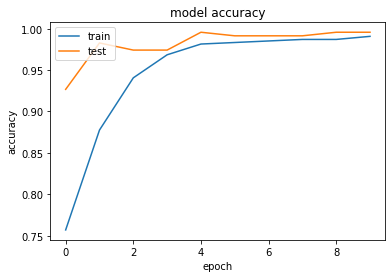

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()